# Deepfake Detection Project: 67-426 
## Team Quarks: Ali & Belal
Fall 2023

---

## Introduction

Deepfake technology, driven by artificial intelligence, has emerged as a significant digital threat, capable of creating realistic-looking videos where individuals appear to say or do things they never did. The potential misuse of deepfake technology for misinformation, fraud, and harassment underscores the importance of developing effective detection methods. This project aims to tackle the challenge of deepfake detection by employing machine learning models to distinguish between genuine and manipulated videos.

---

## Dataset Overview

The dataset utilized in this project originates from the Deepfake Detection Challenge (DFDC) hosted on Kaggle. It provides a large collection of videos, both real and AI-manipulated, allowing for comprehensive training and evaluation of our models. The dataset is organized into training, public validation, and test sets, with the training set being further segmented into 50 files for easier access and handling.

---

## Data Analysis

### Data Loading and Exploration

```python
# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline 
import cv2 as cv
from IPython.display import Video
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load metadata file

In [2]:
df = pd.read_csv('full_metadata.csv')

# Comparing the amount of original vs deepfake videos in the dataset.

In [3]:
n_orig = df['original_file'].unique().shape[0]
n_fake = df['deepfake_file'].unique().shape[0]

print(f"Number of original videos: {n_orig}")
print(f"Number of deepfake videos: {n_fake}")

Number of original videos: 19154
Number of deepfake videos: 100000


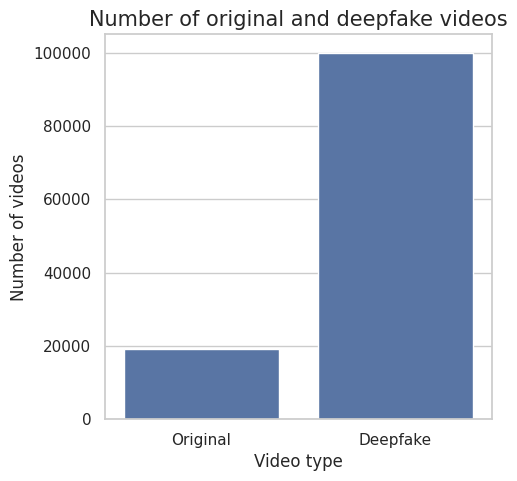

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.barplot(x=['Original', 'Deepfake'], y=[n_orig, n_fake], color="b")
plt.ylabel('Number of videos', fontsize=12)
plt.xlabel('Video type', fontsize=12)
plt.title('Number of original and deepfake videos', fontsize=15)
plt.show()

# Class Distribution Analysis

The dataset exhibits a significant class imbalance:

- **Original Videos**: 19,154
- **Deepfake Videos**: 100,000

This shows a higher prevalence of deepfake videos compared to original videos, with a ratio of approximately 1:5.2. This imbalance may need addressing during model training to avoid bias towards detecting deepfake videos.


# Sample Deepfake Video

Below is a sample from the dataset, showcasing what a deepfake video looks like. Understanding the visual nuances of deepfake videos will be crucial in developing an effective detection model.


In [5]:
Video("sample_data/train_sample_videos/aagfhgtpmv.mp4", embed=True)

# Checking the reuse of orginal videos

In [6]:
df['original_file'].value_counts().tail(10)

original_file
vebmzzbjmw.mp4    1
ybnemycaum.mp4    1
npjtgmzhwb.mp4    1
zdbdbhyplo.mp4    1
qbxpyhzacb.mp4    1
kuzdfabnks.mp4    1
viznmxrjqi.mp4    1
fgmbxfqoze.mp4    1
ijjxgqmbfv.mp4    1
ikokogfuzz.mp4    1
Name: count, dtype: int64

In [7]:
df['original_file'].value_counts().head(10)

original_file
tfyyefqpfs.mp4    40
ypgayhhaxx.mp4    39
rqsotnryhj.mp4    39
zgdtjzfrad.mp4    39
gcyecnxtht.mp4    38
ivctdtckcn.mp4    38
gggxkzqtvh.mp4    37
nvvghjfiqq.mp4    37
wdpsifpppf.mp4    37
xosbvurwon.mp4    37
Name: count, dtype: int64

# Reuse of Original Videos for Deepfake Generation

The analysis reveals that certain original videos are used multiple times to create deepfake versions, with the top original video being utilized to generate 40 deepfake videos.


# Face Detection in Video Frames
In this section, we aim to extract frames from a sample video and utilize OpenCV for face detection. Understanding and visualizing the frame content is the first step towards building a robust deepfake detection model. 


### Extracting a Frame

We'll begin by extracting a frame from a sample video to understand the visual content. The following code demonstrates how to extract the first frame from the video `cqrskwiqng.mp4` and display it using Matplotlib.


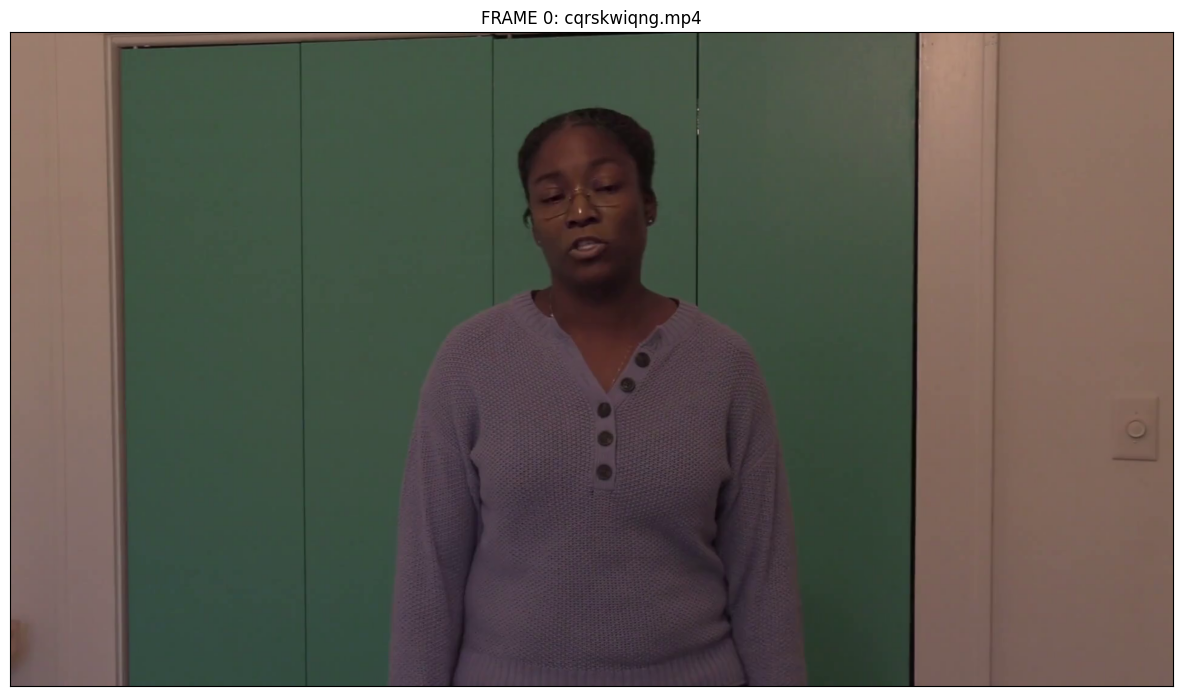

In [3]:
import matplotlib.pylab as plt
train_dir = '/data1/belalm/Capstone/sample_data/train_sample_videos/'
fig, ax = plt.subplots(1,1, figsize=(15, 15))
train_video_files = [train_dir + x for x in os.listdir(train_dir)]
# video_file = train_video_files[10]
video_file = '/data1/belalm/Capstone/sample_data/train_sample_videos/cqrskwiqng.mp4'
cap = cv.VideoCapture(video_file)
success, image = cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release()   
ax.imshow(image)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
plt.grid(False)

### Face Detection using OpenCV and face_recognition package

Now, we will leverage the `face_recognition` package alongside OpenCV to detect faces within the video frame. 

In [8]:
%pip install face_recognition

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Locating Face within an Image

Utilizing the `face_recognition` library, we'll now pinpoint the faces present in a video frame. This library simplifies the process of identifying the coordinates where faces are located within an image.

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 192, Left: 835, Bottom: 415, Right: 1058


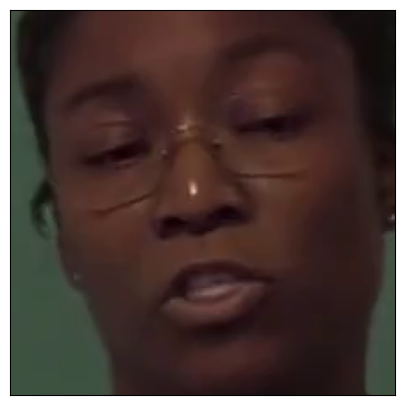

In [4]:
import face_recognition
face_locations = face_recognition.face_locations(image)

from PIL import Image

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    face_image = image[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

### Locating Facial Landmarks within an Image

In this section, we extend our face analysis to identify the landmarks - distinctive points like the corners of the eyes, the tip of the nose, etc., within a face. This is crucial for understanding the geometry of the face which might be altered in deepfake videos. The `face_recognition` library has a simple method to get these landmarks.

The chin in this face has the following points: [(857, 294), (862, 316), (869, 338), (877, 359), (888, 379), (902, 397), (919, 410), (940, 419), (962, 419), (985, 413), (1007, 402), (1026, 386), (1040, 365), (1048, 341), (1051, 315), (1050, 288), (1048, 261)]
The left_eyebrow in this face has the following points: [(866, 252), (873, 238), (886, 230), (902, 228), (915, 232)]
The right_eyebrow in this face has the following points: [(951, 224), (966, 213), (983, 209), (1001, 212), (1015, 223)]
The nose_bridge in this face has the following points: [(936, 256), (938, 271), (939, 285), (940, 300)]
The nose_tip in this face has the following points: [(924, 320), (934, 321), (945, 322), (957, 317), (967, 314)]
The left_eye in this face has the following points: [(883, 280), (892, 275), (902, 272), (914, 273), (905, 277), (895, 280)]
The right_eye in this face has the following points: [(968, 263), (978, 258), (989, 257), (1000, 258), (990, 262), (979, 264)]
The top_lip in this face has the f

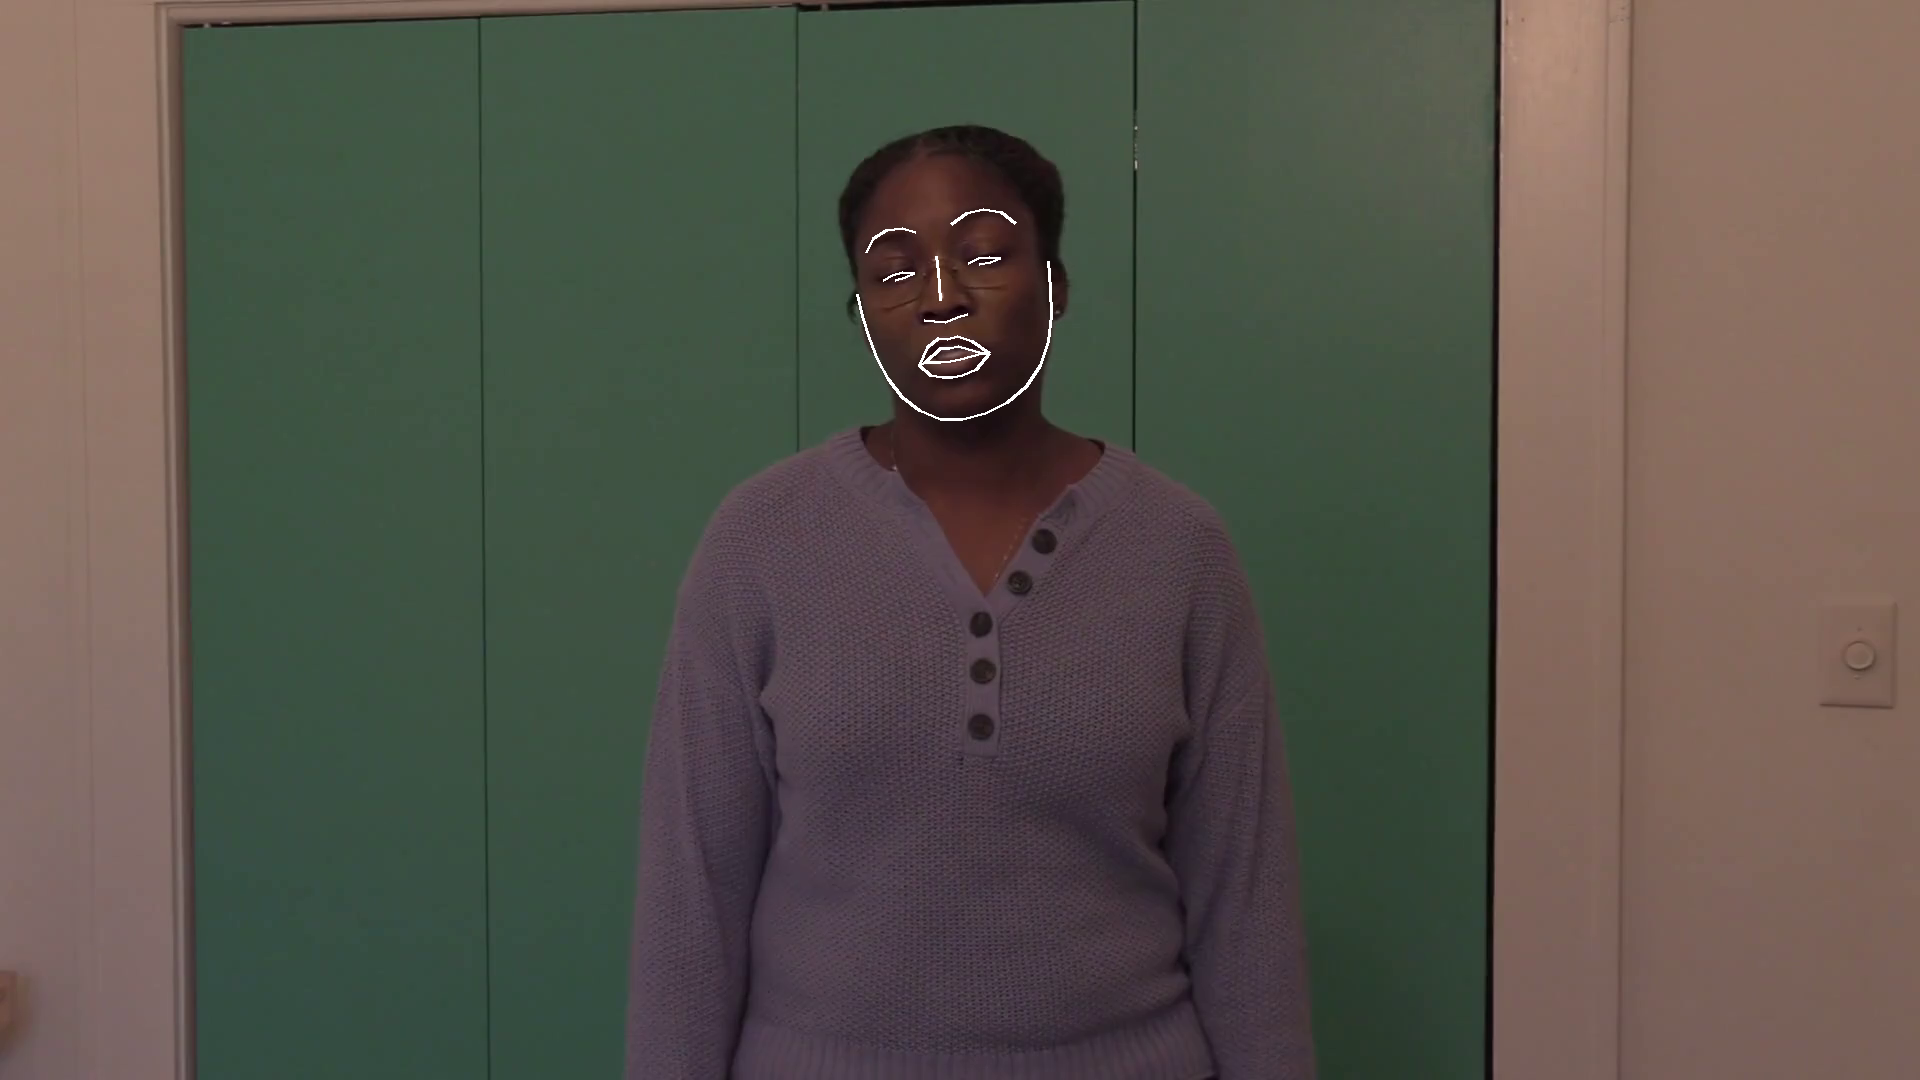

In [5]:
face_landmarks_list = face_recognition.face_landmarks(image)
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # trace out each facial feature in the image with lines
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

### Analysis of Facial Landmark Extraction

The extraction of facial landmarks lays the foundation for many advanced facial analysis tasks. The coordinates of key facial features like the eyes, nose, and mouth can be important in understanding the variations in facial geometry between genuine and deepfake videos. This analysis also opens avenues for feature engineering which is pivotal for building robust deepfake detection models. 


### Displaying Sample Test Examples with Labels

In this section, we display 2 video frames from the dataset, along with their labels indicating whether they are original or deepfake. Each pair comprises the original face image and the corresponding face image with facial landmarks drawn. The goal is to visually inspect the data and see if there are any distinguishable features between real and fake face that could potentially be used for detection. 

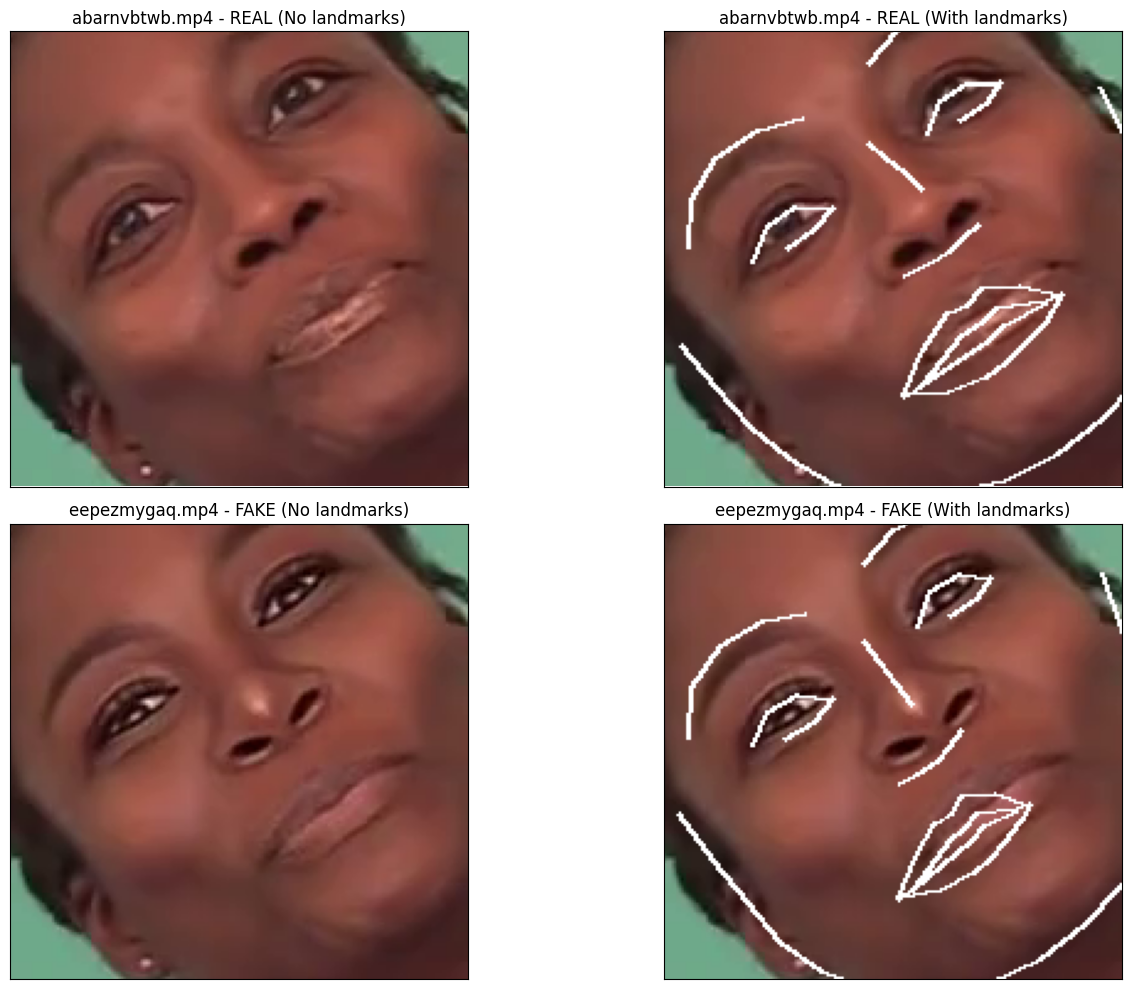

In [20]:
# Video files
videos = ["abarnvbtwb.mp4", "eepezmygaq.mp4"]
labels = ["REAL", "FAKE"]

# Initialize the figure with only two rows now
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.reshape(-1)

i = 0  # Index for subplots

for video, label in zip(videos, labels):
    video_file = f'/data1/belalm/Capstone/sample_data/train_sample_videos/{video}'
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    
    if len(face_locations) > 0:
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        
        # Display face without landmarks
        axs[i].imshow(face_image)
        axs[i].grid(False)
        axs[i].title.set_text(f'{video} - {label} (No landmarks)')
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)
        
        # Display face with landmarks on the full image
        face_landmarks_list = face_recognition.face_landmarks(image)
        if face_landmarks_list:  # Check if landmarks are available
            face_landmarks = face_landmarks_list[0]
            pil_image = Image.fromarray(image)
            d = ImageDraw.Draw(pil_image)
            for facial_feature in face_landmarks.keys():
                d.line(face_landmarks[facial_feature], width=2)
            landmark_face_array = np.array(pil_image)
            landmark_cropped = landmark_face_array[top:bottom, left:right]
            axs[i+1].imshow(landmark_cropped)
            axs[i+1].grid(False)
            axs[i+1].title.set_text(f'{video} - {label} (With landmarks)')
            axs[i+1].xaxis.set_visible(False)
            axs[i+1].yaxis.set_visible(False)
        else:
            axs[i+1].imshow(face_image)
            axs[i+1].grid(False)
            axs[i+1].title.set_text(f'{video} - {label} (Landmarks Not Found)')
            axs[i+1].xaxis.set_visible(False)
            axs[i+1].yaxis.set_visible(False)
        
        i += 2  # Jump to the next row

plt.grid(False)
plt.tight_layout()
plt.show()

## Analysis of Displayed Video Frames and Landmarks

In the displayed frames from the 2 different videos, we observe that the facial landmarks are detected and outlined accurately on the faces present in the frames. These landmarks include contours around the eyes, eyebrows, nose, lips, and chin. This accuracy in facial landmark detection is crucial, as it forms the basis for further analysis and feature extraction for our deepfake detection. We can observe that the fake video has similar highlights, however we can notice that the mouth and nose is more leaning to the left. Also, some of the landmarks appear to be smaller compared to the original. Later on, we will look at how these landmarks are different over time.

The outlined facial landmarks in the images provide a clear visual understanding of the distinct features that can be utilized to identify real versus manipulated content. Through this visualization, we can comprehend how a deep learning model might learn and extract features to distinguish between genuine and deepfake videos. 

Moving forward, leveraging these facial landmarks and other associated features will be essential in training a reliable deepfake detection model. The process of overlaying facial landmarks on the frames also validates the effectiveness and potential utility of facial recognition libraries in this project.


In [9]:
train_sample_metadata = pd.read_json('/data1/belalm/Capstone/sample_data/train_sample_videos/metadata.json').T
sample_set = { # Real: Fake
    "abarnvbtwb.mp4": "eepezmygaq.mp4",
}

def get_all_frames(video_file, max_frames=0):
    cap = cv.VideoCapture(video_file)
    length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    frames = []
    if max_frames == 0:
        max_frames = length
    for i in tqdm(range(max_frames), desc=f"Reading video {video_file}"):
        success, image = cap.read()
        if success:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            frames.append(image)
        else:
            print(f"Warning: Failed to get frame {i} from video {video_file}")
            break
    cap.release()
    return frames

def get_face_locations(video_file):
    face_locations_video = []
    for image in tqdm(get_all_frames(video_file), desc=f"Finding faces in {video_file}"):
        face_locations = face_recognition.face_locations(image)
        if len(face_locations) > 0:
            # Print first face
            face_location = face_locations[0]
            face_locations_video.append(face_location)
    return face_locations_video

def frames_to_video(frames, output_file):
    height = 999999999
    width = 999999999
    # crop video to smallest frame size
    for frame in frames:
        frame_height, frame_width, _ = frame.shape
        if frame_height < height:
            height = frame_height
        if frame_width < width:
            width = frame_width
    size = (width, height)
    # Write to video file, frame by frame, using cv2, output as MP4
    out = cv.VideoWriter(output_file, cv.VideoWriter_fourcc(*'mp4v'), 30, size)
    for frame in tqdm(frames, desc=f"Writing video {output_file}"):
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        frame = frame[0:height, 0:width]
        out.write(frame)
    out.release()

def get_face_landmarks(face_image, retry=0):
    face_landmarks_list = face_recognition.face_landmarks(face_image)
    print(f"Found {len(face_landmarks_list)} face landmarks")
    if len(face_landmarks_list) > 0:
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        return landmark_face_array
    else:
        if retry > 0:
            return get_face_landmarks(face_image, retry - 1)
        if retry == 0:
            return None
        
def get_face_landmarks_video(video_file):
    face_landmarks_video = []
    for image in tqdm(get_all_frames(video_file), desc=f"Finding face landmarks in {video_file}"):
        face_locations = face_recognition.face_locations(image)
        if len(face_locations) > 0:
            # Print first face
            face_location = face_locations[0]
            top, right, bottom, left = face_location
            face_image = image[top:bottom, left:right]
            landmark_face_array = get_face_landmarks(face_image, retry=5)
            face_landmarks_video.append(landmark_face_array)
    return face_landmarks_video

def get_face_landmarks_video_pair(video_file1, video_file2):
    face_landmarks_video1 = get_face_landmarks_video(video_file1)
    face_landmarks_video2 = get_face_landmarks_video(video_file2)
    return face_landmarks_video1, face_landmarks_video2

## Further Analysis into Video Frames and Landmarks

With real and fake videos, we want to take a look at the face positions and landmarks to better understand the differences between the original and deepfake videos. First, we acquire the location of the subject's face in each frame for both the real and fake video. We then calculate the central point of the face (centroid), and graph its movement throughout the video.

Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4: 100%|██████████| 300/300 [00:01<00:00, 214.01it/s]
Finding faces in /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4:   7%|▋         | 21/300 [00:18<03:57,  1.18it/s]

Finding faces in /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4: 100%|██████████| 300/300 [04:14<00:00,  1.18it/s]
Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4: 100%|██████████| 300/300 [00:01<00:00, 219.51it/s]
Finding faces in /data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4: 100%|██████████| 300/300 [04:15<00:00,  1.17it/s]


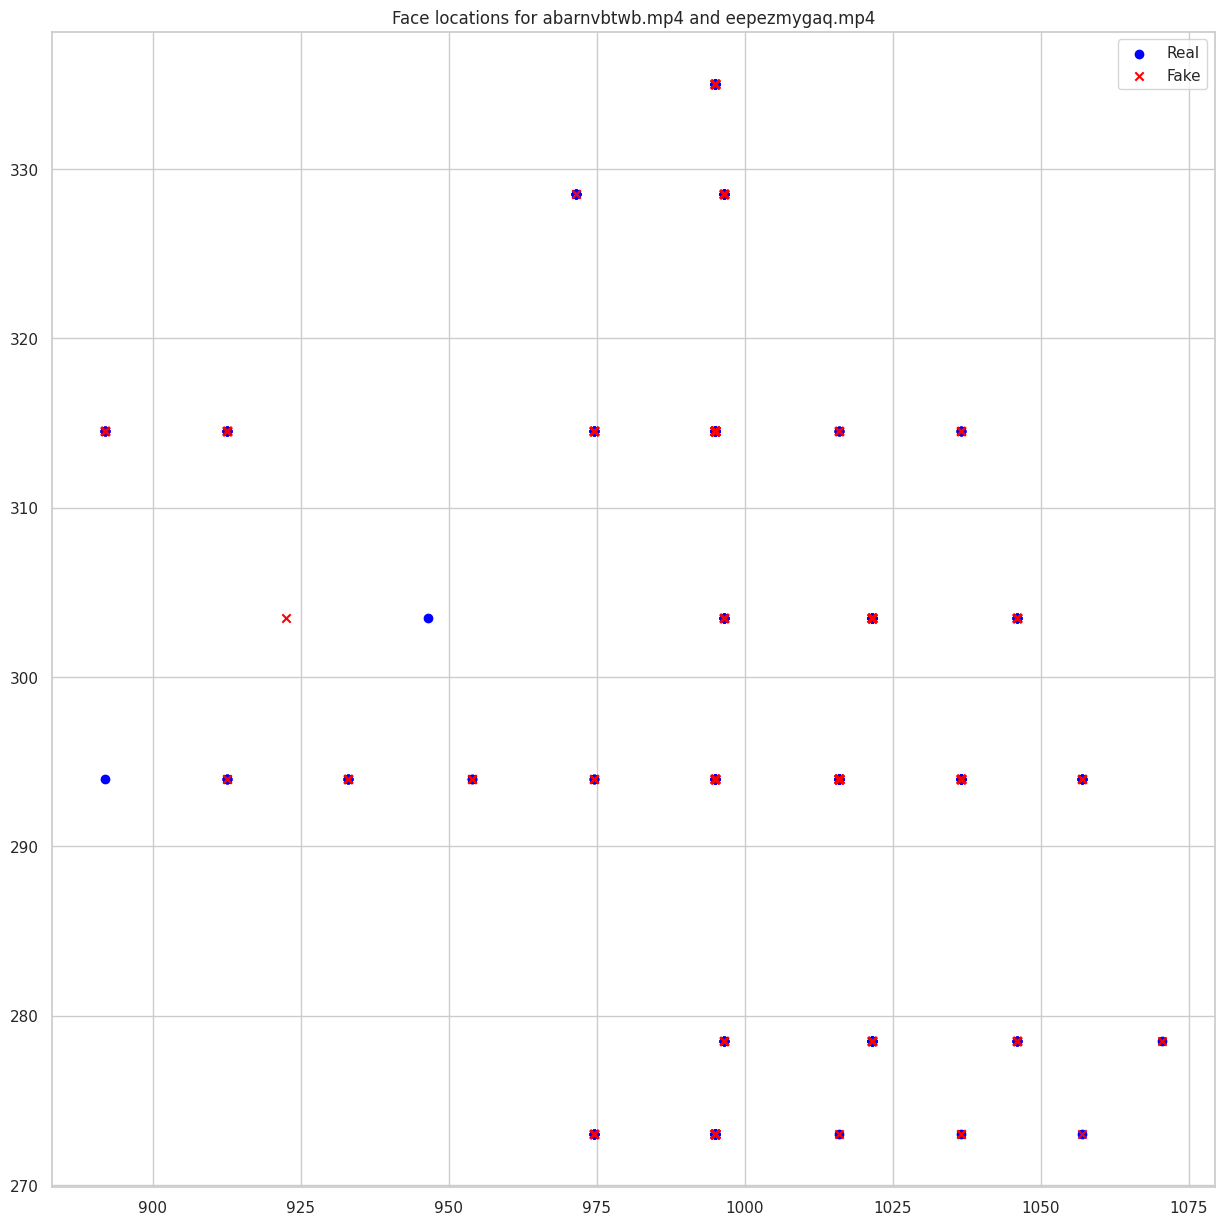

In [17]:
for real_video, fake_video in sample_set.items():
    real_video_file =f'/data1/belalm/Capstone/sample_data/train_sample_videos/{real_video}'
    fake_video_file = f'/data1/belalm/Capstone/sample_data/train_sample_videos/{fake_video}'
    real_face_locations = get_face_locations(real_video_file)
    fake_face_locations = get_face_locations(fake_video_file)
    # graph the central point of face locations
    real_central_points = []
    for face_location in real_face_locations:
        top, right, bottom, left = face_location
        real_central_points.append(((left+right)/2, (top+bottom)/2))
    fake_central_points = []
    for face_location in fake_face_locations:
        top, right, bottom, left = face_location
        fake_central_points.append(((left+right)/2, (top+bottom)/2))
    plt.figure(figsize=(15, 15))
    plt.scatter(*zip(*real_central_points), color='blue', label='Real', marker="o")
    plt.scatter(*zip(*fake_central_points), color='red', label='Fake', marker='x')
    plt.title(f"Face locations for {real_video} and {fake_video}")
    plt.legend()
    plt.show()

As can be seen, there is a great variation for the centroids of fake videos, while the real video is seen as more consistent. One element of deepfake videos is that every time a deepfake is generated on a frame, it introduces inconsistencies that we can trace. Between 300 frames, we can see this variation more clearly.

In our feature collection phase, we hope to indentify more of these insonsistencies, by looking at the fluctuations in the movements of individual facial features (such as the nose, eyes, mouth). While real videos will be smoother and have more gradual movements on the frame-to-frame scale, we expect that synthetic videos will have identifiable inconsistencies we can use to classify the deepfake.

# Feature Extraction
In this section, we will focus on extracting features from the videos based on our exploratory data analysis (EDA) with facial recognition. Our primary objective is to differentiate real and fake videos by leveraging the facial landmarks.

## Introduction to Feature Extraction
Facial landmarks can be pivotal in distinguishing between real and fake videos. The consistency (or lack thereof) in the placement and shape of these landmarks can potentially be a telltale sign of a manipulated video. We will begin by extracting the facial landmarks of one real and one fake video from the same example above, and we will plot the landmarks overtime to see if there is a noticable differnce.

In [44]:
def temporal_consistency_landmarks(video_file, max_seconds=10):
    cap = cv.VideoCapture(video_file)
    frame_rate = int(cap.get(cv.CAP_PROP_FPS))
    sampling_interval = frame_rate // 10
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(min(frame_rate * max_seconds, total_frames)):
        ret, frame = cap.read()
        if i % sampling_interval == 0:  # Take one frame every 'sampling_interval' frames
            frames.append(frame)

    cap.release()

    previous_landmarks = None
    movement_patterns = {
        feature: [] for feature in [
            'chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 
            'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip'
        ]
    }
    
    for image in frames:
        current_landmarks = face_recognition.face_landmarks(image)
        if current_landmarks:
            current_landmarks = current_landmarks[0]
            if previous_landmarks:
                for feature in movement_patterns.keys():
                    distances = [
                        np.linalg.norm(np.array(point) - np.array(previous_landmarks[feature][i])) 
                        for i, point in enumerate(current_landmarks[feature])
                    ]
                    movement_patterns[feature].append(np.mean(distances))
            previous_landmarks = current_landmarks
    
    return movement_patterns

real_temporal_features = temporal_consistency_landmarks(f'/data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4')

fake_temporal_features = temporal_consistency_landmarks(f'/data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4')



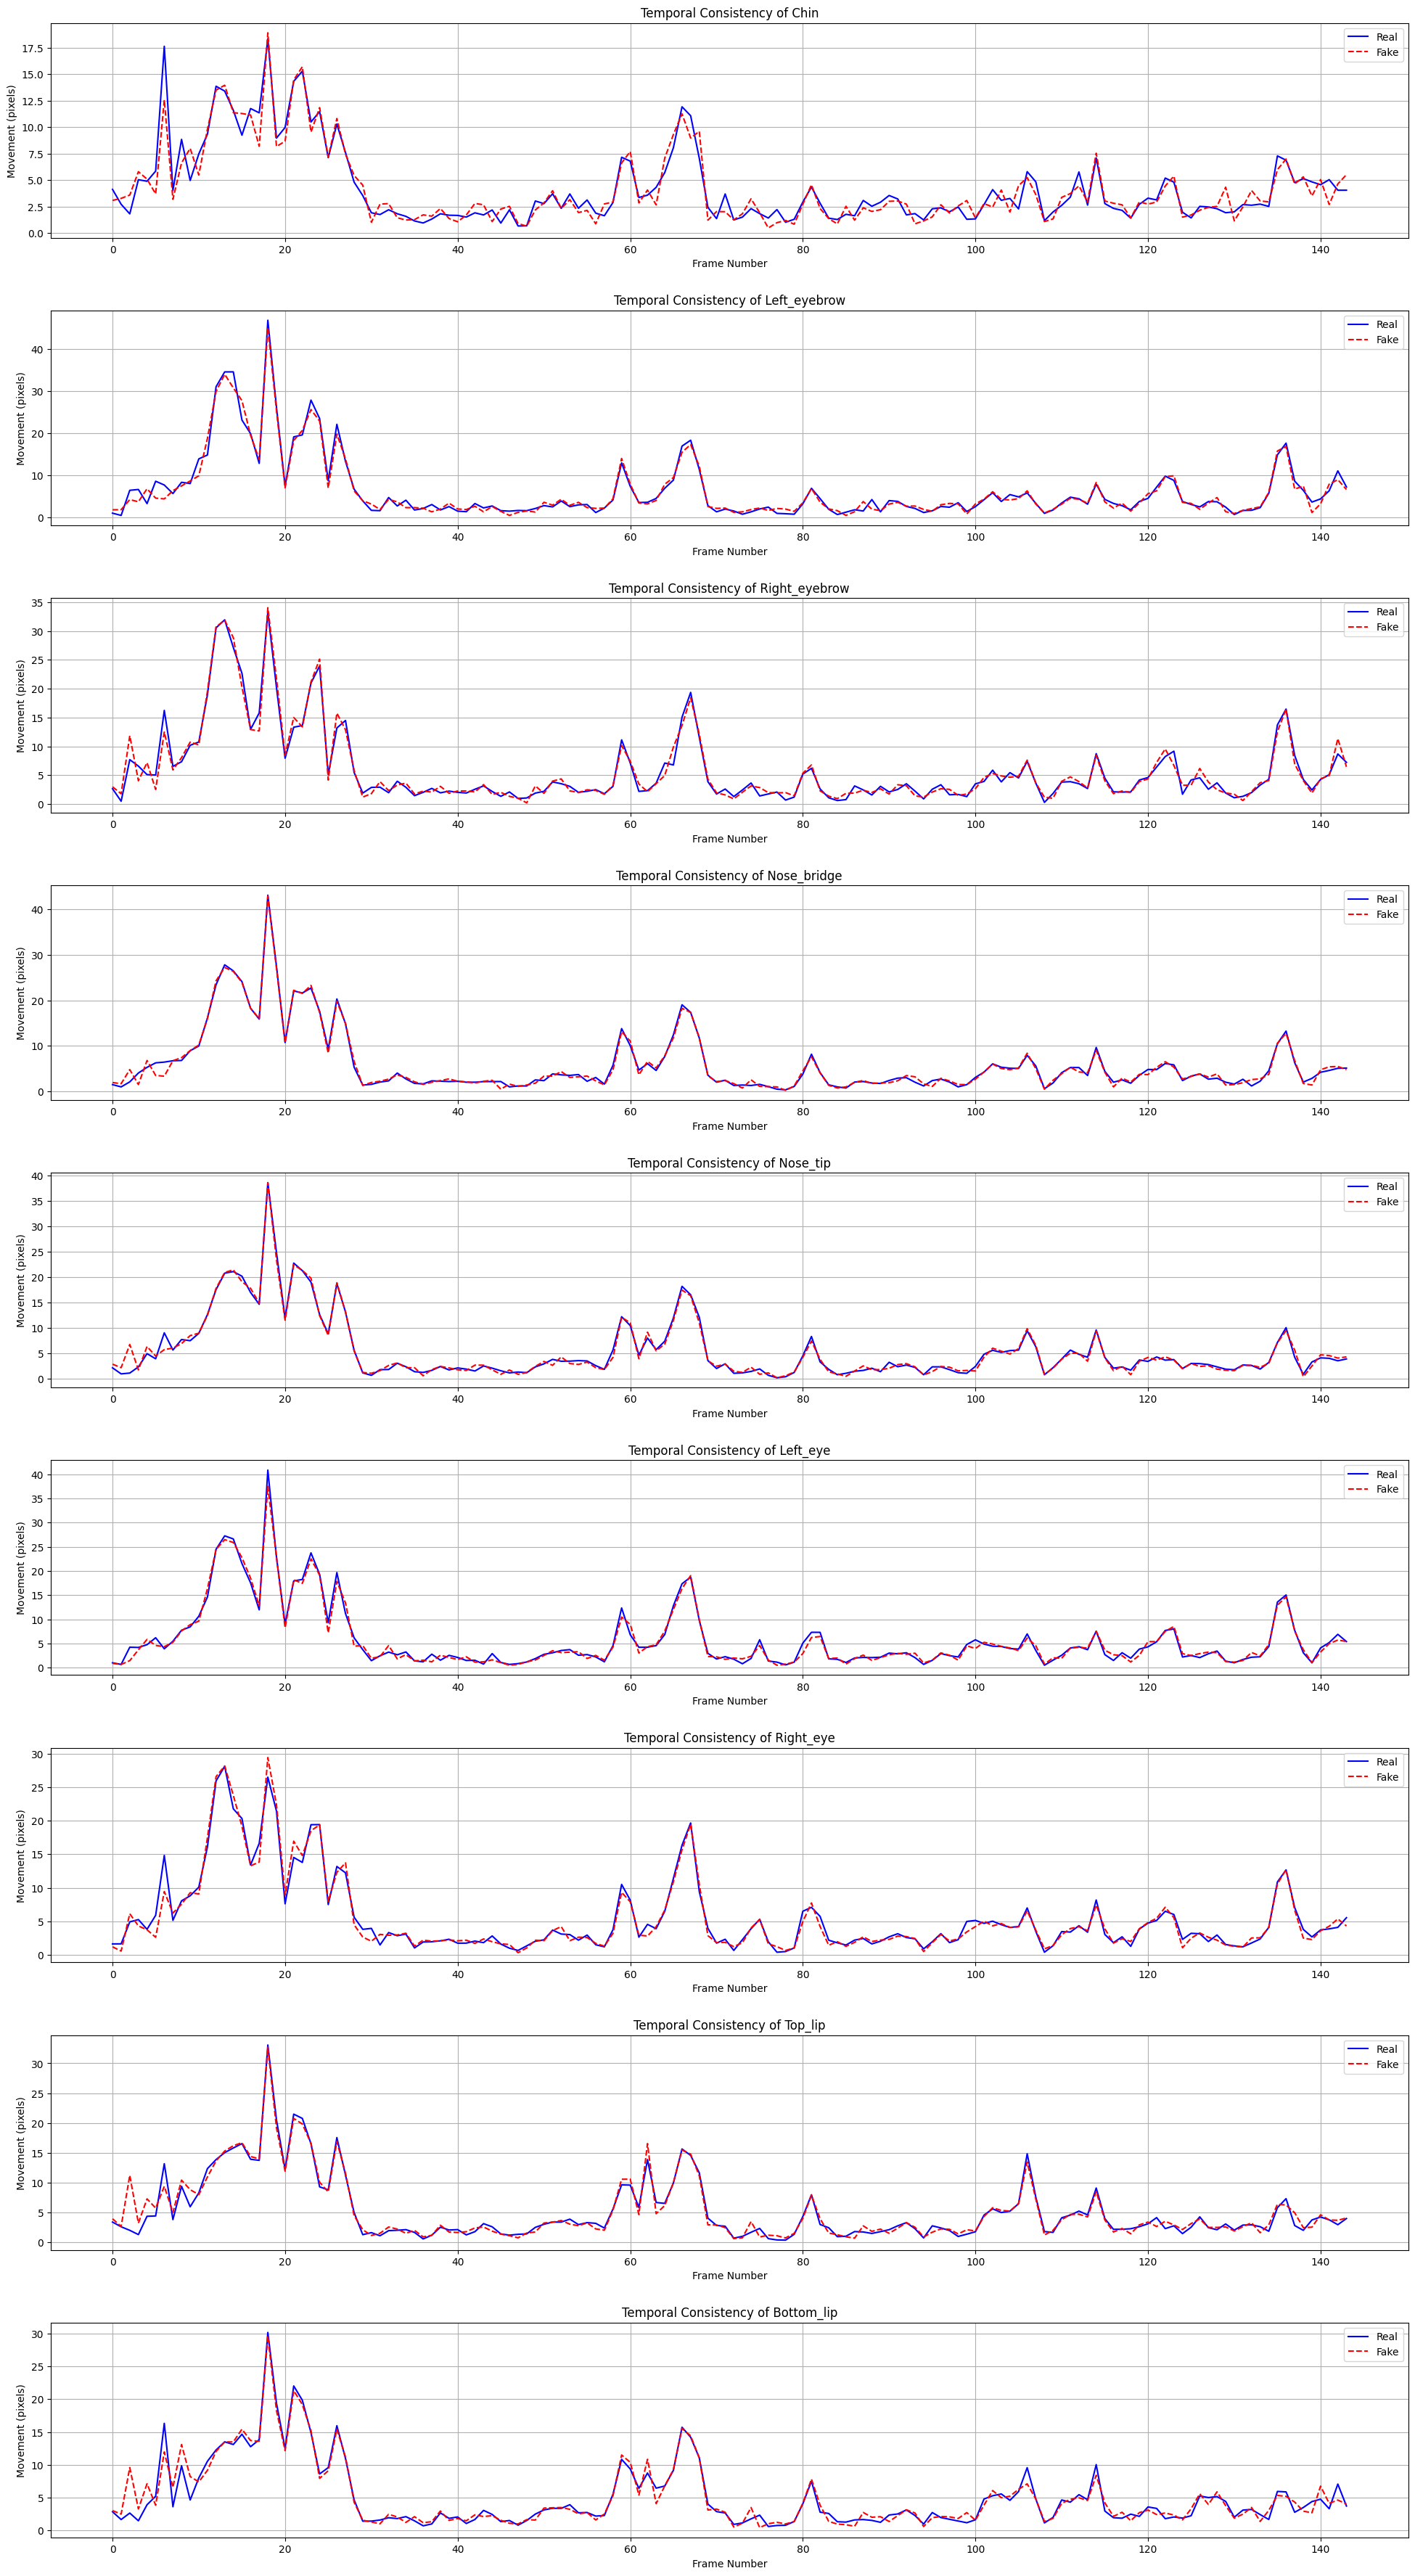

In [45]:
def compare_temporal_features(real_features, fake_features):
    num_features = len(real_features)
    plt.figure(figsize=(20, 4 * num_features))  
    
    for feature in real_features.keys():
        plt.subplot(num_features, 1, list(real_features.keys()).index(feature) + 1)
        
        plt.plot(real_features[feature], label=f"Real", linestyle='-', marker='', color='blue')
        plt.plot(fake_features[feature], label=f"Fake", linestyle='--', marker='', color='red')
        
        plt.title(f"Temporal Consistency of {feature.capitalize()}")
        plt.ylabel("Movement (pixels)")
        plt.xlabel("Frame Number")
        plt.legend(loc='upper right')
        plt.grid(True)
        
    plt.tight_layout(pad=2.5)
    plt.show()


compare_temporal_features(real_temporal_features, fake_temporal_features)


## Analysis of Temporal Consistency of Facial Landmarks
In our preliminary analysis of a single example, we observed that real videos typically exhibit smoother facial landmark movements, though they can occasionally present sudden spikes indicative of natural gestures. In contrast, deepfake videos might show abrupt and unnatural shifts, sometimes even displaying less pronounced movements than genuine footage. We can also observe that the chin landmark had the most differnces. These initial observations suggest that temporal consistency could be used as a feature.

## Landmark Distortion Analysis
When videos are manipulated to produce deepfakes, the process can introduce subtle distortions in the facial landmarks. Even though the deepfake might look visually convincing, the landmark positions and their relative distances might differ slightly from those in genuine videos. By analyzing these distortions, we can potentially detect anomalies introduced by the deepfake generation process. We will extract the facial landmarks then compute pairwise distances between the landmarks to capture the facial structure and compare these distances across consecutive frames to detect inconsistencies. We will be using the same example as above.

In [49]:
def pairwise_distances(landmarks):
    return np.sqrt(np.sum((landmarks[:, np.newaxis] - landmarks[np.newaxis, :]) ** 2, axis=-1))

def get_all_frames_2(video_file, max_frames=0):
    cap = cv.VideoCapture(video_file)
    length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    if max_frames == 0 or max_frames > length:
        max_frames = length
        interval = 1
    else:
        interval = length // max_frames
    
    frames = []

    for i in tqdm(range(0, length, interval), desc=f"Reading video {video_file}"):
        cap.set(cv.CAP_PROP_POS_FRAMES, i)
        success, image = cap.read()
        if success:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            frames.append(image)
        else:
            print(f"Warning: Failed to get frame {i} from video {video_file}")
            break

    cap.release()
    return frames

def landmark_distortion(video_file, max_frames=100):
    frames = get_all_frames_2(video_file, max_frames=max_frames)
    distortion_scores = []
    distances_last_frame = None

    for frame in frames:
        face_landmarks = face_recognition.face_landmarks(frame)
        if face_landmarks:
            # Flatten the landmarks
            flattened_landmarks = np.array([point for feature in face_landmarks[0].values() for point in feature])
            distances_current_frame = pairwise_distances(flattened_landmarks)
            
            if distances_last_frame is not None:
                distortion = np.sum(np.abs(distances_current_frame - distances_last_frame))
                distortion_scores.append(distortion)
                
            distances_last_frame = distances_current_frame

    return distortion_scores

real_distortion_scores = landmark_distortion(f'/data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4')
fake_distortion_scores = landmark_distortion(f'/data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4')

Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4:   8%|▊         | 8/100 [00:00<00:04, 22.77it/s]

Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s]
Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


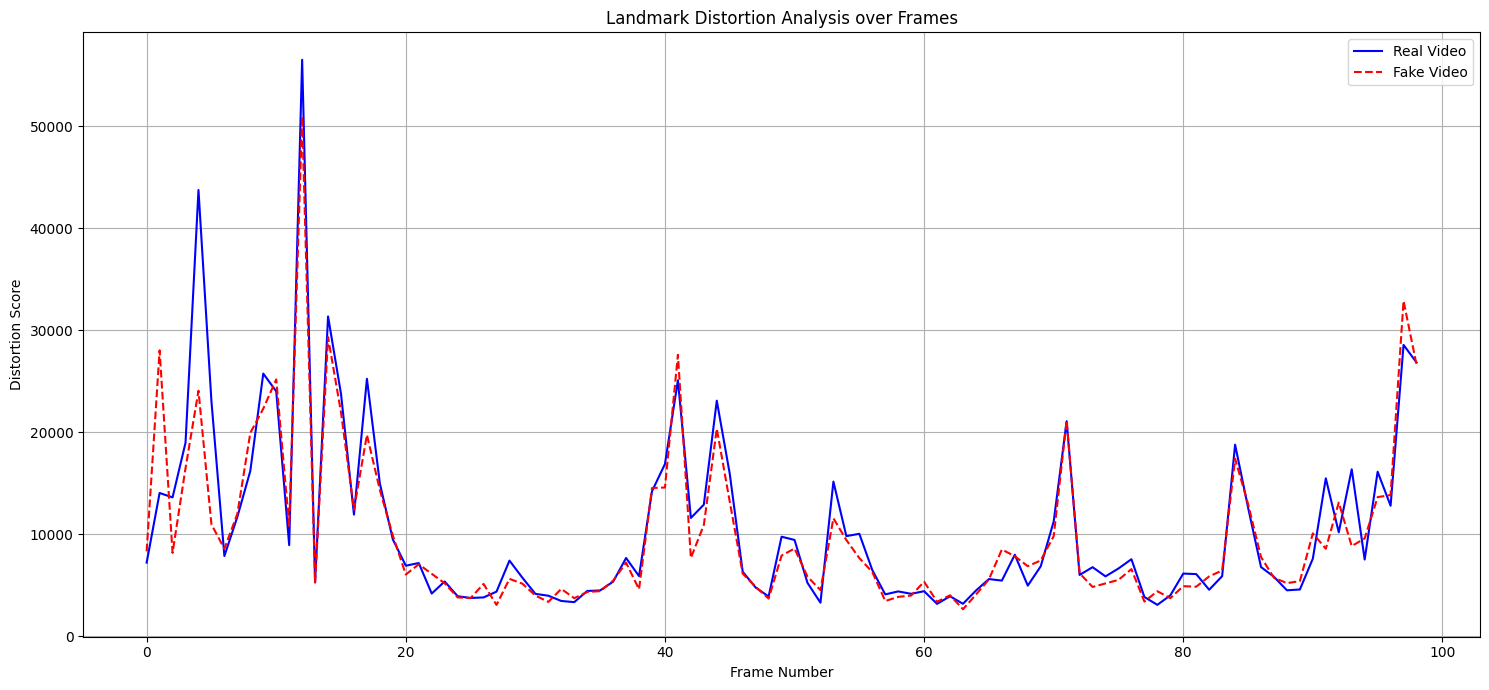

In [50]:
plt.figure(figsize=(15, 7))

# Plot the distortion scores
plt.plot(real_distortion_scores, label="Real Video", color='blue')
plt.plot(fake_distortion_scores, label="Fake Video", color='red', linestyle='--')

plt.title("Landmark Distortion Analysis over Frames")
plt.xlabel("Frame Number")
plt.ylabel("Distortion Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis Of Landmark Distotion
While both videos showcase shifts in landmarks across frames, the fake video often manifests higher distortion magnitudes. Interestingly, despite the real video occasionally displaying pronounced spikes in distortions, the fake video doesn't always mirror these. At times, it even presents dips where the real video spikes, suggesting the deepfake generation may not always replicate natural movements found in genuine videos. These observed inconsistencies might serve as potential indicators in distinguishing between real and manipulated content.

## Facial Symmetry Analysis
Facial symmetry can be another key feature to consider. Genuine videos will likely display natural asymmetries inherent to human faces, while deepfakes, due to their generative nature, might produce faces with more pronounced or less natural symmetries.




In [51]:
def symmetry_score(landmarks):
    # Points considered for symmetry check (based on 68-point facial landmarks)
    symmetry_points = [
        (1, 17), (2, 16), (3, 15), (4, 14), (5, 13), (6, 12), (7, 11), 
        (18, 27), (19, 26), (20, 25), (21, 24), (37, 44), (38, 43), 
        (40, 42), (46, 49), (47, 48), (32, 35), (33, 34), (50, 53), 
        (51, 52), (54, 57), (55, 56), (58, 61), (59, 60), (62, 65), 
        (63, 66), (67, 64)
    ]
    
    score = 0
    for point1, point2 in symmetry_points:
        # Calculate Euclidean distance for corresponding points
        score += np.sqrt((landmarks[point1][0] - landmarks[point2][0]) ** 2 + 
                         (landmarks[point1][1] - landmarks[point2][1]) ** 2)
    
    return score

def average_symmetry(video_file, max_frames=100):
    frames = get_all_frames_2(video_file, max_frames=max_frames)
    total_score = 0
    
    for frame in frames:
        face_landmarks = face_recognition.face_landmarks(frame)
        if face_landmarks:
            # Flatten the landmarks
            flattened_landmarks = [point for feature in face_landmarks[0].values() for point in feature]
            total_score += symmetry_score(flattened_landmarks)

    return total_score / len(frames) if frames else 0

real_symmetry_score = average_symmetry(f'/data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4')
fake_symmetry_score = average_symmetry(f'/data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4')


Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4:   8%|▊         | 8/100 [00:00<00:04, 22.51it/s]

Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/abarnvbtwb.mp4: 100%|██████████| 100/100 [00:11<00:00,  8.62it/s]
Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/eepezmygaq.mp4: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


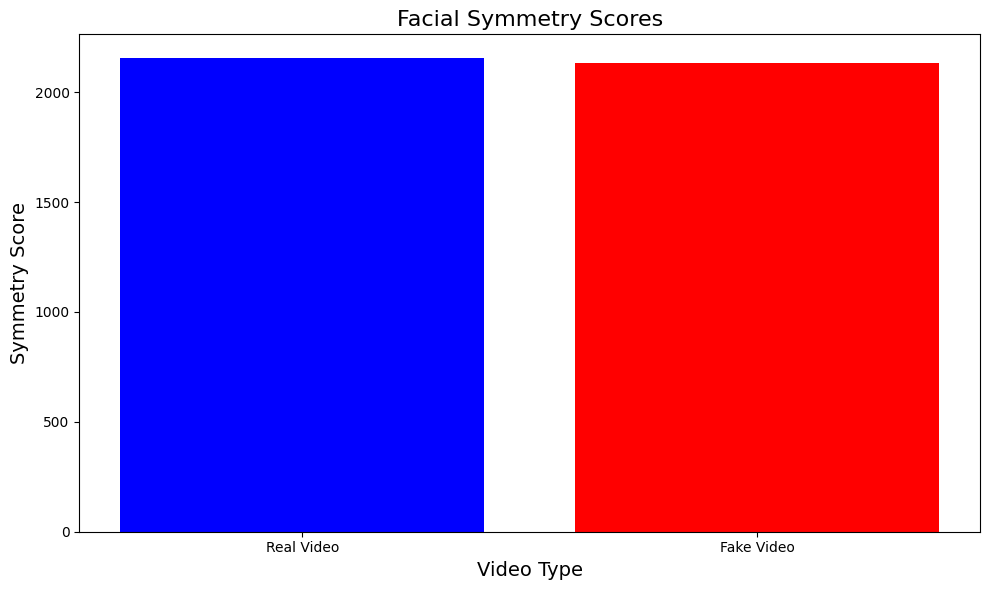

In [52]:
def plot_symmetry_scores(real_score, fake_score):
    # Data to plot
    labels = ['Real Video', 'Fake Video']
    scores = [real_score, fake_score]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(labels, scores, color=['blue', 'red'])
    plt.xlabel('Video Type', fontsize=14)
    plt.ylabel('Symmetry Score', fontsize=14)
    plt.title('Facial Symmetry Scores', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the symmetry scores
plot_symmetry_scores(real_symmetry_score, fake_symmetry_score)

## Analysis Of Facial Symmetry
The proximity in facial symmetry scores between real and fake videos reveals the sophisticated capabilities of modern deepfake generation techniques. This suggests that solely relying on facial symmetry as a distinguishing feature may not be sufficiently robust, however a small differnce could still help us in detecting. 

## Landmark Motion Consistency Analysis
Landmark motion consistency is the consistency of facial landmark movements across a video. In authentic videos, the movement of facial landmarks (like the corners of the mouth, eyes, or nose tip) should generally follow a smooth and consistent trajectory. However, deepfakes might occasionally exhibit irregularities in these trajectories, as the model might not always ensure temporal consistency between frames. We will try to see if the differcnes are clear using the same set of the real and fake video.

In [53]:
def get_landmarks(video_file, max_frames=100):
    frames = get_all_frames_2(video_file, max_frames=max_frames)
    all_landmarks = []

    for frame in frames:
        face_landmarks = face_recognition.face_landmarks(frame)
        if face_landmarks:
            # Flatten the landmarks
            flattened_landmarks = np.array([point for feature in face_landmarks[0].values() for point in feature])
            all_landmarks.append(flattened_landmarks)
            
    return np.array(all_landmarks)

def landmark_motion_consistency(video_file, max_frames=100):
    landmarks = get_landmarks(video_file, max_frames=max_frames)
    motion_scores = []

    for i in range(1, len(landmarks)):
        motion = np.sum(np.abs(landmarks[i] - landmarks[i-1]))
        motion_scores.append(motion)

    return motion_scores

real_motion_scores = landmark_motion_consistency(f'/data1/belalm/Capstone/sample_data/train_sample_videos/aelfnikyqj.mp4')
fake_motion_scores = landmark_motion_consistency(f'/data1/belalm/Capstone/sample_data/train_sample_videos/ahbweevwpv.mp4')

Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/aelfnikyqj.mp4: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]
Reading video /data1/belalm/Capstone/sample_data/train_sample_videos/ahbweevwpv.mp4: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s]


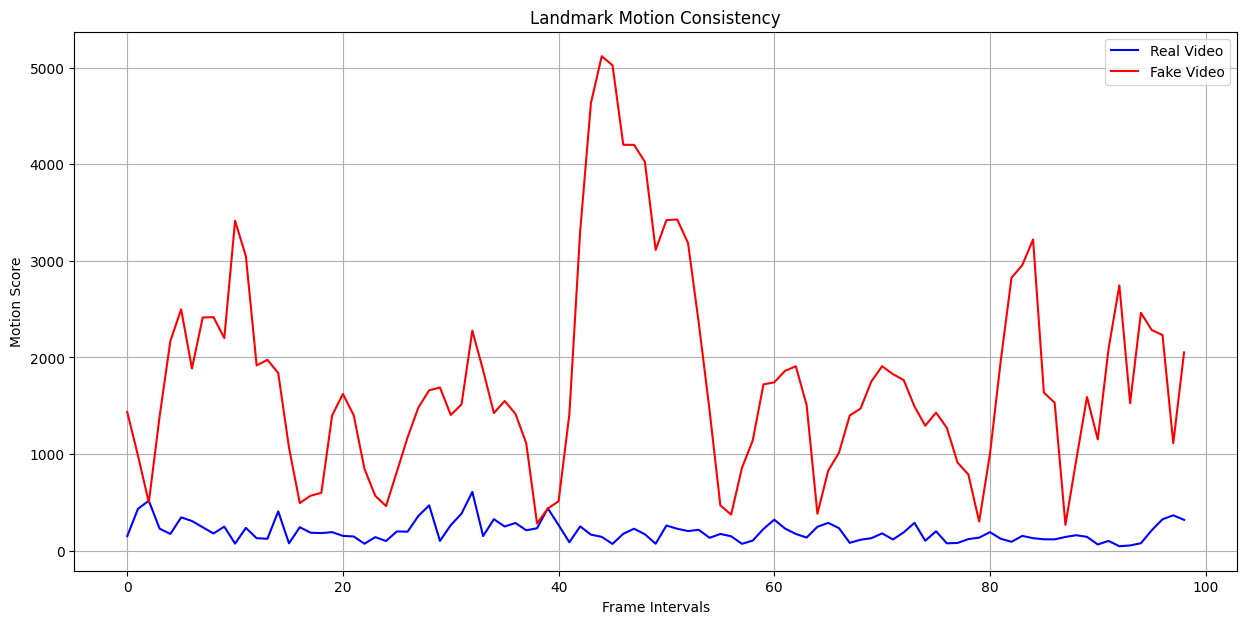

In [56]:

plt.figure(figsize=(15, 7))
plt.plot(real_motion_scores, label='Real Video', color='blue')
plt.plot(fake_motion_scores, label='Fake Video', color='red')
plt.title('Landmark Motion Consistency')
plt.xlabel('Frame Intervals')
plt.ylabel('Motion Score')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of Analysis Of landmark Motion Consistency
Upon visual examination of the landmark motion scores between real and fake videos, there is a distinct difference in the consistency of facial landmarks. The real video generally exhibits relatively lower motion scores, indicating consistent and subtle movements across frames. In contrast, the fake video manifests considerably higher motion scores, suggesting abrupt and inconsistent shifts in facial landmarks. This inconsistency in the fake video could be attributed to the imperfections in the deepfake generation process. The noticeably larger fluctuations in motion scores for the fake video can serve as a potential indicator for deepfake detection.